In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline
import torch.utils.data as Data

In [2]:
ds = pd.read_csv('../data/mnist/train.csv').values
print ds.shape

(42000, 785)


In [3]:
# Data Preparation
X_train = ds[:10000, 1:].reshape((-1, 1, 28, 28)) / 255.0
y_train = ds[:10000, 0]

X_test = ds[5000:5100, 1:].reshape((-1, 1, 28, 28)) / 255.0
y_test = ds[5000:5100, 0]
# y_train = one_hot(y_train_labels, 10)

print ds.shape,X_train.shape, y_train.shape

(42000, 785) (10000, 1, 28, 28) (10000,)


In [4]:
class CAE(torch.nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        #has 2 convolution operation 1 converts it to 16 
        #downsample
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        #optional in order to diff encoder and decoder
        self.enc_linear=nn.Linear(8*2*2,2)
        self.dec_linear=nn.Linear(2,8*2*2)
        #upsample
        #deconv was used before transpose came into picture
        #unpooling is reverse of pool function
        #they both were ambiguous hence tanspse came into pictre
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            #to convert to 0-1
            nn.Sigmoid()
        )
    def encode(self,x):
        x=self.encoder(x)
        x=x.view(x.size(0),-1)
        #x passed to a fully connected layer
        x=self.enc_linear(x)
        return x #it is a 2d vector
        
    def decode(self,x):
        x=self.dec_linear(x) #converted to 32 
        x=x.view(x.size(0),8,2,2) #reshaping to number of examples,8X2X2
        x=self.decoder(x) 
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    # if encode and decode are not used seperatly
    
  #   def forward(self, x):
   #     x = self.encoder(x)
    #    x = self.decoder(x)
     #   return x

In [5]:
model = CAE()
type(model)

__main__.CAE

In [6]:
# model(torch.FloatTensor(X_train[:1])).min()

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
loss_func = torch.nn.MSELoss()
type(loss_func)

torch.nn.modules.loss.MSELoss

In [11]:
def make_batch(train, labels, batch_size=10, gpu=False):
    start = 0
    stop = start + batch_size
    while start < train.shape[0]:
        if gpu:
            yield Variable(torch.FloatTensor(train[start:stop]), requires_grad=True).cuda(), Variable(torch.FloatTensor(train[start:stop])).cuda()
        else:
            yield Variable(torch.FloatTensor(train[start:stop]), requires_grad=True), Variable(torch.FloatTensor(train[start:stop]))
        start = stop
        stop = start + batch_size

In [13]:
for epoch in range(500):
    for step, (b_x, b_y) in enumerate(make_batch(X_train, y_train, 256,False)):   # gives batch data, normalize x when iterate train_loader
        # print step,
        output = model(b_x)               # cnn output
        # print output.size(), output.sum(dim=0)
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        
        # for params in model.parameters():
        #     print params.grad.cpu().data.sum() # Y U no train!!!
        optimizer.step()                # apply gradients

        if epoch % 10 == 0 and step %200 == 0:
            test_output = model(torch.FloatTensor(X_test))
            test_loss = loss_func(test_output, torch.FloatTensor(X_test))
            acc = test_loss.cpu().data.numpy()
            # pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()
            # accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| Step: ', step, '| Acc: ', acc)

('Epoch: ', 0, '| Step: ', 0, '| Acc: ', array(0.26071417, dtype=float32))
('Epoch: ', 10, '| Step: ', 0, '| Acc: ', array(0.10993474, dtype=float32))
('Epoch: ', 20, '| Step: ', 0, '| Acc: ', array(0.10993474, dtype=float32))
('Epoch: ', 30, '| Step: ', 0, '| Acc: ', array(0.10993474, dtype=float32))
('Epoch: ', 40, '| Step: ', 0, '| Acc: ', array(0.10993474, dtype=float32))
('Epoch: ', 50, '| Step: ', 0, '| Acc: ', array(0.10993474, dtype=float32))
('Epoch: ', 60, '| Step: ', 0, '| Acc: ', array(0.10993474, dtype=float32))
('Epoch: ', 70, '| Step: ', 0, '| Acc: ', array(0.10993474, dtype=float32))
('Epoch: ', 80, '| Step: ', 0, '| Acc: ', array(0.10993474, dtype=float32))
('Epoch: ', 90, '| Step: ', 0, '| Acc: ', array(0.10993474, dtype=float32))
('Epoch: ', 100, '| Step: ', 0, '| Acc: ', array(0.10993474, dtype=float32))
('Epoch: ', 110, '| Step: ', 0, '| Acc: ', array(0.10993474, dtype=float32))
('Epoch: ', 120, '| Step: ', 0, '| Acc: ', array(0.10993474, dtype=float32))
('Epoch: '

In [14]:
 model.cpu()
# # model.cud
# a()

CAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_linear): Linear(in_features=32, out_features=2, bias=True)
  (dec_linear): Linear(in_features=2, out_features=32, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace)
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [15]:
o = model(torch.FloatTensor(X_train[10:11])).data.numpy()
emb=model.encode(torch.FloatTensor(X_train[:1000])).data.numpy()

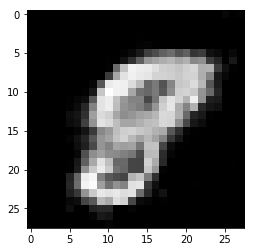

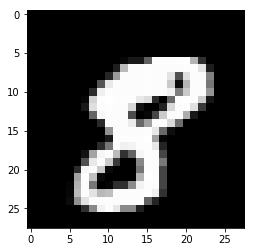

In [16]:
plt.figure(0)
plt.imshow(o.reshape((28, 28)), cmap='gray')

plt.figure(1)
plt.imshow(X_train[10:11].reshape((28, 28)), cmap='gray')